Fit a neural network to the Credit Card Default data (https://islp.readthedocs.io/en/latest/datasets/Default.htmlLinks to an external site.). Use a single hidden layer with 10 units, and dropout regularization. Compare the classification performance of your model with that of linear logistic regression.

Hint: looking at the following sections of the lab might help: Single Layer Network on Hitters Data, Multilayer Network on the MNIST Digit Data.

In [47]:
from ISLP import load_data
Default = load_data('Default')
Default.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

In [2]:
Default.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [3]:
Default['student'].value_counts()

student
No     7056
Yes    2944
Name: count, dtype: int64

In [48]:
n = Default.shape[0]

In [ ]:
%pip install torchinfo

In [ ]:
%pip install torchvision

In [6]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
from glob import glob
import json
# json is a data format suitable for large data structures


Seed set to 0


In [49]:
model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default).to_numpy()
Y = Default['default'].to_numpy()

In [50]:
(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

In [51]:
# convert string to float
X_train = X_train.astype(int)
# convert 'No' to 0 and 'Yes' to 1
Y_train = (Y_train == 'Yes').astype(int)

X_test = X_test.astype(int)
Y_test = (Y_test == 'Yes').astype(int)


In [53]:
# Linear logistic regression
def_linear_logistic = LogisticRegression(penalty='none',
                           max_iter=1000)
def_linear_logistic.fit(X_train, Y_train)
# Calculate mean absolute error
Y_pred = def_linear_logistic.predict(X_test)
mean_absolute_error = np.mean(np.abs(Y_pred - Y_test))
mean_absolute_error

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.029994001199760048

In [ ]:
# def_lm = LinearRegression().fit(X_train, Y_train)
# Yhat_test = def_lm.predict(X_test)
# # Yhat_test
# np.abs(Yhat_test - Y_test).mean()

0.08096216623414383

In [ ]:
# scaler = StandardScaler(with_mean=True, with_std=True)
# lasso = Lasso(warm_start=True, max_iter=30000)
# standard_lasso = Pipeline(steps=[('scaler', scaler),
#                                  ('lasso', lasso)])

In [ ]:
# X_s = scaler.fit_transform(X_train)
# n = X_s.shape[0]
# lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
# param_grid = {'lasso__alpha': np.exp(np.linspace(0, np.log(0.01), 100))
#              * lam_max}

In [ ]:
# cv = KFold(10,
#            shuffle=True,
#            random_state=1)
# grid = GridSearchCV(standard_lasso,
#                     param_grid,
#                     cv=cv,
#                     scoring='neg_mean_absolute_error')
# grid.fit(X_train, Y_train);

In [ ]:
# trained_lasso = grid.best_estimator_
# Yhat_test = trained_lasso.predict(X_test)
# np.fabs(Yhat_test - Y_test).mean()  

0.06057280802891136

In [28]:
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10), # fully connected Layer
            nn.ReLU(), # activation function
            nn.Dropout(0.4), # dropout layer: regularization
            nn.Linear(10, 1)) # fully connected Layer

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))


In [29]:
def_model = DefaultModel(X.shape[1])


In [30]:
summary(def_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [6666, 3]                 [6666]                    --
├─Flatten: 1-1                           [6666, 3]                 [6666, 3]                 --
├─Sequential: 1-2                        [6666, 3]                 [6666, 1]                 --
│    └─Linear: 2-1                       [6666, 3]                 [6666, 10]                40
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 1]                 11
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.34
Input size (MB): 0.08
Forward/backward pass size (MB): 0.59
Params size (MB): 0.00
Estimated Total Size (MB): 0.67

In [31]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
def_train = TensorDataset(X_train_t, Y_train_t)

In [32]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
def_test = TensorDataset(X_test_t, Y_test_t)


In [33]:
max_num_workers = rec_num_workers() 
print(max_num_workers) # cpu

12


In [34]:
def_dm = SimpleDataModule(def_train,
                          def_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=def_test)
# import 32 images at a time

In [35]:
def_module = SimpleModule.regression(def_model,
                           metrics={'mae':MeanAbsoluteError()})


In [36]:
def_logger = CSVLogger('logs', name='default') # log the results

In [37]:
def_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=def_logger,
                      callbacks=[ErrorTracker()])
def_trainer.fit(def_module, datamodule=def_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | DefaultModel | 51     | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
def_trainer.test(def_module, datamodule=def_dm)



Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.029504001140594482
        test_mae            0.07721396535634995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.029504001140594482, 'test_mae': 0.07721396535634995}]

In [39]:
def_results = pd.read_csv(def_logger.experiment.metrics_file_path)

In [40]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

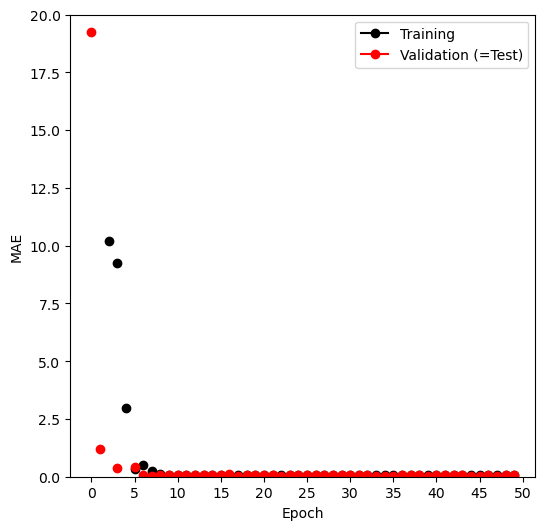

In [43]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(def_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 20])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [ ]:
def_model.eval() 
preds = def_module(X_test_t)
torch.abs(Y_test_t - preds).mean() 

tensor(0.0772, grad_fn=<MeanBackward0>)

# Comparison of the models
The performance (test MAE) of the linear logistic model, and the single neural network model is 
0.029994001199760048 and 0.07721396535634995. 

From this, we could see that the simple linear logistics model performed much better than the neural network model.

In [45]:
del(Default,
    def_model, def_dm,
    def_logger,
    def_test, def_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    def_trainer, def_module)
# delete the variables to free up memory
